# Mode Choice with Slow MS Gates

We investigate how mode choice can be used to improve the fidelity of MS gates in the presence of optical crosstalk.

## Code Setup

### Imports

In [1]:
import scipy.constants
from scipy.constants import physical_constants
import numpy as np
from numpy import exp, sqrt, sin
from math import factorial
import itertools
import matplotlib.pyplot as plt

In [2]:
import importlib
import sys, os
from pathlib import Path
sys.path.append('tools/')
import IonChainTools as ict
import MSFidelityEstimation as msfe
importlib.reload(msfe)
from MSFidelityEstimation import *

### Functions

## Device Parameters

We pick physical parameters to match those used on the QSCOUT system.

In [3]:
# Ytterbium171
M=171*physical_constants['atomic mass constant'][0]

# Laser wavelength
# carrier_wavelen = # 355*1e-9 # 355nm, from "frequency robust ..." paper
# carrier_wavenum = 2*π/carrier_wavelen # Laser wavenumber (k)
# carrier_freq = scipy.constants.c*carrier_wavenum
qbit_splitting = 2*π*12.643*1e6 # qubit splitting, from "Engineering The ..." paper
raman_wavelen = 355*1e-9 # 355nm, from "frequency robust ..." paper
raman_freq = 2*π*scipy.constants.c/raman_wavelen
kvec = qbit_splitting/scipy.constants.c*np.sqrt(2)

# Rabi rate
Ωpeak = 2*π*190*1e3 # 190MHz, quoted in "Frequency-robust MS ..." paper

In [4]:
# Trap specifications
# Axial COM of 0.52MHz and highest radial mode of 2.296MHz are quoted in 
# "Frequency-robust Mølmer-Sørensen gates via balanced contributions of multiple motional modes"
# νz = 2*π*0.52*1e6 # 0.52MHz, not used here since we adjust νz to fix ion spacing
νr = 2*π*2.296*1e6 # 2.296MHz

In [5]:
# Optical Crosstalk, from "ENGINEERING THE QUANTUM SCIENTIFIC COMPUTING OPEN USER TESTBED"
# These values are scaled such that Ω=1 for the target ion
neighΩ = 0.0236 # Rabi frequency on neighbor of target ion
nneighΩ = 0.006 # Rabi frequency on next neighbor of target ion

In [6]:
# Blue and Red beam phases
# Below should implement X gate
ϕB = π/2
ϕR = π/2

## Fixed Axial Frequency

**Unfortunately, if we fix axial frequency, when there are a high number of ions in the string, more ions have non-negligible crosstalk than can be simulated. I'll look at how to deal with this.**

## Fixed Ion Spacing through Axial Frequency Adjustment

### Maintaining Ion Spacing

We will consider a fixed minimum ion spacing of 4$\mu$m.

In [7]:
minspacing = 4e-6

We calculate the axial trap frequencies necessary to keep this spacing constant as $N$, the number of ions in the string, increases.

In [8]:
Nmax = 20
axialfreqs_for_fixed_spacing = {N:ict.axialfreq_from_minimum_spacing(N, M, minspacing) for N in range(2, Nmax+1)}

We also calculate the radial frequencies necessary to keep the string stable with these lower axial frequencies.

In [10]:
radialfreqs_for_fixed_spacing = {N : ict.trap_freq_ratio_for_stablility(N)*axialfreqs_for_fixed_spacing[N] for N in range(2,Nmax+1)}

### Resolving A Single Radial Mode

These radial and axial frequencies will dictate the frequency spacing of the radial modes we want to use for the MS gate. We calculate the minimum frequency spacing between radial modes and accordingly set the gate time to make sure that the individual modes can still be resolved. Contribution to the gate from a mode is inversely proportional to the detuning of the laser from the sideband corresponding to the mode. Thus is we want only one mode to take part in the gate, we need the detuning from the target mode to be much smaller than the detuning from the nearest spectator mode.

If the minimum frequency spacing of the radial modes is $\Delta \nu$ and the detuning of the laser from the target mode is $\delta$, then we require $\delta << \Delta \nu$. The associated gate time therefore be at least

$$
\tau = \frac{2\pi K}{\delta} >> \frac{2\pi K}{\Delta \nu}
$$

where K is the number of loops in phase space we want to use to complete the gate. We'll choose $K=1$ to minimize gate time.

In [12]:
radialmodes = ict.calcRadialModes(Nmax, νratio = radialfreqs_for_fixed_spacing[Nmax]/axialfreqs_for_fixed_spacing[Nmax])
min_radial_mode_spacing = np.min([radialmodes[i+1][0]-radialmodes[i][0] for i in range(Nmax-1)])*axialfreqs_for_fixed_spacing[Nmax]
print(f"Minimum spacing of radial modes: {min_radial_mode_spacing/(2*π)/1e3:.4g}kHz")

Minimum spacing of radial modes: 8.064kHz


In [13]:
slowness = 0.01 # How much to slow gate by to achieve the δ<<Δν
δ = min_radial_mode_spacing*slowness
τ = 2*π/δ
print(f"Slow gate time: {τ*1e6:.0f}μs")

Slow gate time: 12401μs


### Gate Fidelities

Now we calculate the gate fidelity between every pair of ions in strings of various lengths.

In [15]:
fids_fixedspacing = {}
Nmax = 20
modetype='radial'
modextalk=True
K=1
bw=2.5e-6
for N in range(2, Nmax+1, 2):
    νz = axialfreqs_for_fixed_spacing[N]
    trapspec = TrapSpec(νz, radialfreqs_for_fixed_spacing[N])
    fidsarr = np.zeros((N,N,N))
    devicespec = TIDeviceSpec(N, trapspec, qbit_splitting, raman_freq, M)
    for targets in itertools.combinations(range(N),2):
        for m in range(N):
            ωd, Ω = calc_necessary_sideband_detuning_and_rabi_freq(devicespec, targets, m, modetype, τ, K=K)
            Ωvals = Ω*ict.Ωvals_from_gaussian_crosstalk(N, targets, νz, M, bw)
            #Ωvals = Ω*Ωvals_from_fixed_neighbor_xtalk(N, targets, 0.05)
            mslaserspec = MSLaserSpec(ωd, Ωvals, ϕB, ϕR)
            simmodes = list(range(N)) if modextalk==True else [m]
            msopspec = MSOpSpec(devicespec, mslaserspec, τ, targets=targets, m=m, modetype=modetype, K=K)
            ρf, ionindices = MS_Analytical_zeroinitalstate_tracemodes(msopspec, simmodes=simmodes,modetype=modetype, modetrunc=2)
            fidions = targets
            traceindices = [ionindices.index(i) for i in fidions]
            ρred = ρf.ptrace(traceindices)
            fid = (abs(ρred[0,0]) + abs(ρred[3,3]) + abs(2*ρred[3,0].imag))/2
            fidsarr[targets[0],targets[1],m] = fidsarr[targets[1],targets[0],m] = fid
    fids_fixedspacing[N] = fidsarr
    print(N, flush=True)

2
4
6
8
10
12
14
16
18
20


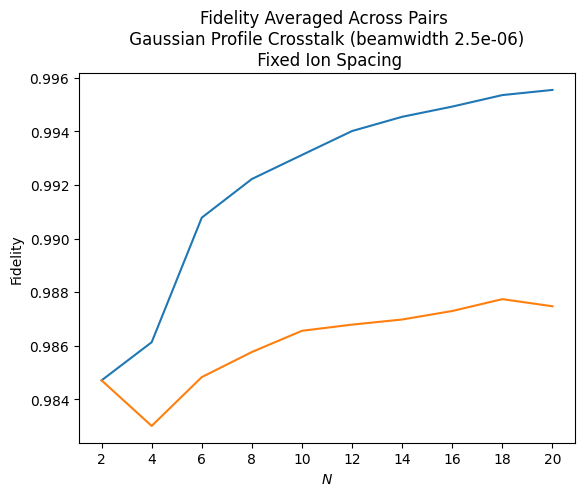

In [16]:
avgfids_COM_fixedspacing = [np.average([fidsarr[i,j,N-1] for i,j in itertools.combinations(range(N),2)]) for N,fidsarr in fids_fixedspacing.items()]
avgfids_best_fixedspacing = [np.average([np.max(fidsarr[i,j,:]) for i,j in itertools.combinations(range(N),2)]) for N,fidsarr in fids_fixedspacing.items()]
fig, ax = plt.subplots()
ax.plot(np.arange(2,Nmax+1,2), avgfids_best_fixedspacing, label="Avg Fid Using Best Mode")
ax.plot(np.arange(2,Nmax+1,2), avgfids_COM_fixedspacing, label="Avg Fid Always Using COM Mode")
ax.set_xlabel('$N$')
ax.set_xticks(np.arange(2,Nmax+1,2))
ax.set_ylabel("Fidelity")
ax.set_title(f"Fidelity Averaged Across Pairs \n Gaussian Profile Crosstalk (beamwidth {bw:.2g}) \n Fixed Ion Spacing");